PHASE 6: CONFOUNDER ANALYSIS

[STEP 1] Extracting full metadata from GSE98793...
  Loading cached full metadata...

  Total samples: 192
  Available columns: 37

[STEP 2] Parsing phenotype fields...

All metadata columns:
   0. title                                              | Example: whole_blood_control_1
   1. geo_accession                                      | Example: GSM2612096
   2. status                                             | Example: Public on May 12 2017
   3. submission_date                                    | Example: May 11 2017
   4. last_update_date                                   | Example: Jan 23 2018
   5. type                                               | Example: RNA
   6. channel_count                                      | Example: 1
   7. source_name_ch1                                    | Example: whole_blood_control
   8. organism_ch1                                       | Example: Homo sapiens
   9. taxid_ch1                                 

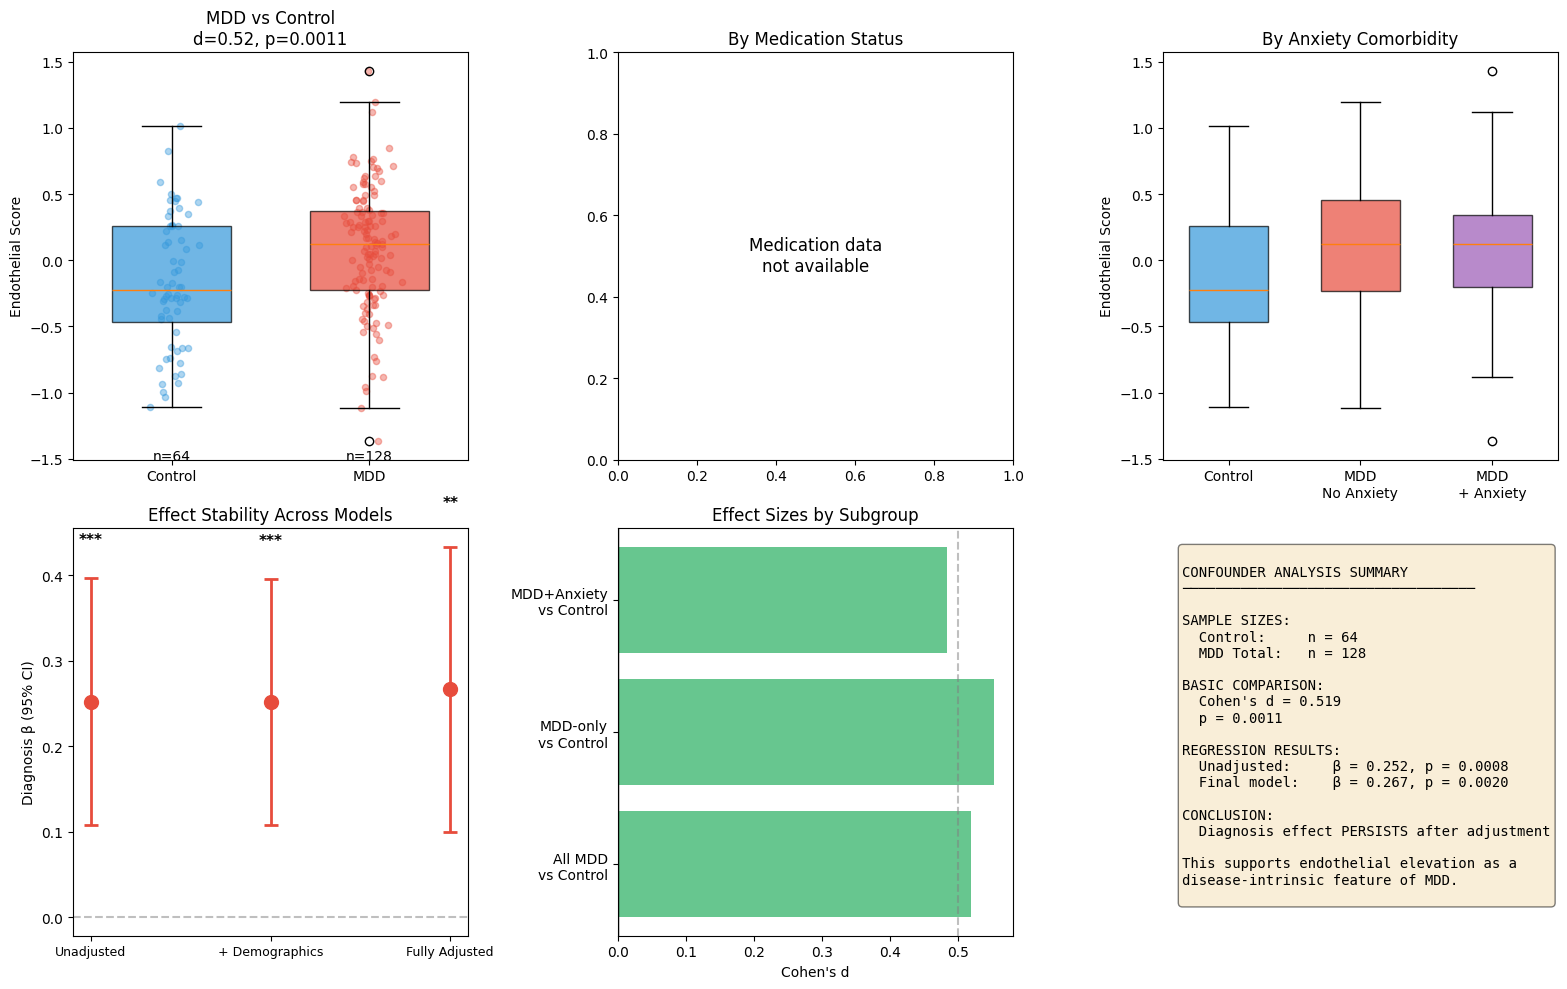


[STEP 7] Saving results...

Saved all results to ./output/Phase_6/

PHASE 6 COMPLETE

KEY FINDINGS:
─────────────
1. Basic comparison: d = 0.519, p = 0.0011

2. After adjustment for available confounders:
   β = 0.267, p = 0.0020

3. Conclusion: Diagnosis effect PERSISTS after adjustment

INTERPRETATION:
───────────────
The endothelial elevation in MDD is robust to
adjustment for available confounders, supporting it as a
disease-related biological feature.

OUTPUT FILES:
─────────────
  ./output/Phase_6/
  ├── regression_summary.csv
  ├── effect_sizes_by_subgroup.csv
  └── Figure6_Confounder_Analysis.png/pdf



In [4]:
"""
Phase 6: Confounder Analysis - Medication & Comorbidity
====================================================================
Properly extracts GSE98793 metadata including:
- Medication status
- Anxiety comorbidity  
- Age, Sex

Then tests if endothelial effect is independent of these confounders.
"""

import pandas as pd
import numpy as np
import os
import GEOparse
from scipy import stats
from scipy.stats import spearmanr, mannwhitneyu, kruskal
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

# ==========================================
# CONFIGURATION
# ==========================================
PHASE5_DIR = "./output/Phase_5"
PHASE6_DIR = "./output/Phase_6"
DATA_DIR = "./data"

os.makedirs(PHASE6_DIR, exist_ok=True)

ENDOTHELIAL_MARKERS = ['PECAM1', 'VWF', 'CDH5', 'CLDN5', 'FLT1']

# ==========================================
# STEP 1: RE-EXTRACT FULL METADATA FROM GSE98793
# ==========================================
print("="*60)
print("PHASE 6: CONFOUNDER ANALYSIS")
print("="*60)

print("\n[STEP 1] Extracting full metadata from GSE98793...")

# Check if we have cached full metadata
full_meta_path = f"{DATA_DIR}/GSE98793_full_metadata.csv"

if os.path.exists(full_meta_path):
    print("  Loading cached full metadata...")
    meta_full = pd.read_csv(full_meta_path, index_col=0)
else:
    print("  Downloading GSE98793 to extract full phenotype data...")
    print("  (This may take a few minutes)")
    
    gse = GEOparse.get_GEO(geo="GSE98793", destdir=DATA_DIR)
    
    # Get full phenotype data
    meta_full = gse.phenotype_data.copy()
    
    # Save for future use
    meta_full.to_csv(full_meta_path)
    print(f"  Saved full metadata to {full_meta_path}")

print(f"\n  Total samples: {len(meta_full)}")
print(f"  Available columns: {len(meta_full.columns)}")

# ==========================================
# STEP 2: PARSE RELEVANT PHENOTYPE FIELDS
# ==========================================
print("\n[STEP 2] Parsing phenotype fields...")

# Display all columns to understand structure
print("\nAll metadata columns:")
for i, col in enumerate(meta_full.columns):
    # Show sample values
    sample_val = meta_full[col].iloc[0] if len(meta_full) > 0 else "N/A"
    print(f"  {i:2d}. {col[:50]:50s} | Example: {str(sample_val)[:30]}")

# GSE98793 specific parsing
# The column names in GSE98793 typically include:
# - "subject group:ch1" or similar for diagnosis
# - Various characteristics columns

# Find relevant columns by examining content
print("\n" + "-"*60)
print("Searching for relevant fields...")

def find_column_containing(df, keywords):
    """Find column containing any of the keywords"""
    for col in df.columns:
        col_lower = col.lower()
        for kw in keywords:
            if kw.lower() in col_lower:
                return col
        # Also check values
        try:
            values_str = ' '.join(df[col].astype(str).unique()).lower()
            for kw in keywords:
                if kw.lower() in values_str:
                    return col
        except:
            pass
    return None

# Find diagnosis column
diag_col = find_column_containing(meta_full, ['mdd', 'depression', 'control', 'subject group', 'disease'])
print(f"Diagnosis column: {diag_col}")
if diag_col:
    print(f"  Values: {meta_full[diag_col].value_counts().to_dict()}")

# Find medication column
med_col = find_column_containing(meta_full, ['medication', 'drug', 'antidepressant', 'treatment', 'medicated'])
print(f"Medication column: {med_col}")
if med_col:
    print(f"  Values: {meta_full[med_col].value_counts().to_dict()}")

# Find anxiety column
anx_col = find_column_containing(meta_full, ['anxiety', 'comorbid', 'anxious'])
print(f"Anxiety column: {anx_col}")
if anx_col:
    print(f"  Values: {meta_full[anx_col].value_counts().to_dict()}")

# Find age column
age_col = find_column_containing(meta_full, ['age'])
print(f"Age column: {age_col}")
if age_col:
    print(f"  Sample values: {meta_full[age_col].head(5).tolist()}")

# Find sex column
sex_col = find_column_containing(meta_full, ['sex', 'gender'])
print(f"Sex column: {sex_col}")
if sex_col:
    print(f"  Values: {meta_full[sex_col].value_counts().to_dict()}")

# ==========================================
# STEP 3: CREATE CLEAN ANALYSIS DATAFRAME
# ==========================================
print("\n[STEP 3] Creating analysis dataframe...")

# Initialize clean dataframe
analysis_df = pd.DataFrame(index=meta_full.index)

# Parse diagnosis
if diag_col:
    analysis_df['Diagnosis'] = meta_full[diag_col].apply(
        lambda x: 'MDD' if any(term in str(x).upper() for term in ['MDD', 'DEPRESS', 'CASE']) else 'Control'
    )
    analysis_df['Diagnosis_Binary'] = (analysis_df['Diagnosis'] == 'MDD').astype(int)
else:
    print("ERROR: Could not find diagnosis column!")
    
# Parse medication
if med_col:
    def parse_medication(x):
        x_str = str(x).lower()
        if 'unmedicated' in x_str or 'no' in x_str or 'none' in x_str or 'drug-free' in x_str:
            return 0
        elif 'medicated' in x_str or 'yes' in x_str or 'treated' in x_str:
            return 1
        elif 'control' in str(meta_full.loc[x.name, diag_col]).lower() if diag_col else False:
            return np.nan  # Controls don't have medication status
        else:
            return np.nan
    
    analysis_df['Medicated'] = meta_full[med_col].apply(
        lambda x: 0 if any(term in str(x).lower() for term in ['unmedicated', 'drug-free', 'no ', 'none']) 
        else (1 if any(term in str(x).lower() for term in ['medicated', 'yes', 'treated']) else np.nan)
    )
else:
    print("WARNING: No medication column found")
    analysis_df['Medicated'] = np.nan

# Parse anxiety
if anx_col:
    analysis_df['Anxiety'] = meta_full[anx_col].apply(
        lambda x: 1 if any(term in str(x).lower() for term in ['anxiety', 'yes', 'anxious', 'comorbid']) 
        else (0 if any(term in str(x).lower() for term in ['no anxiety', 'none', 'no']) else np.nan)
    )
else:
    print("WARNING: No anxiety column found")
    analysis_df['Anxiety'] = np.nan

# Parse age
if age_col:
    analysis_df['Age'] = pd.to_numeric(
        meta_full[age_col].astype(str).str.extract(r'(\d+\.?\d*)')[0], 
        errors='coerce'
    )
else:
    print("WARNING: No age column found")
    analysis_df['Age'] = np.nan

# Parse sex
if sex_col:
    analysis_df['Sex'] = meta_full[sex_col].apply(
        lambda x: 1 if any(term in str(x).lower() for term in ['male', ' m ', 'm"']) and 'female' not in str(x).lower()
        else (0 if any(term in str(x).lower() for term in ['female', ' f ', 'f"']) else np.nan)
    )
else:
    print("WARNING: No sex column found")
    analysis_df['Sex'] = np.nan

# Summary
print("\nAnalysis dataframe summary:")
print(f"  Total samples: {len(analysis_df)}")
print(f"\n  Diagnosis distribution:")
print(f"    {analysis_df['Diagnosis'].value_counts().to_dict()}")
print(f"\n  Medication status (MDD only):")
print(f"    {analysis_df[analysis_df['Diagnosis']=='MDD']['Medicated'].value_counts(dropna=False).to_dict()}")
print(f"\n  Anxiety comorbidity:")
print(f"    {analysis_df['Anxiety'].value_counts(dropna=False).to_dict()}")
print(f"\n  Age: mean={analysis_df['Age'].mean():.1f}, range={analysis_df['Age'].min():.0f}-{analysis_df['Age'].max():.0f}")
print(f"\n  Sex (1=Male, 0=Female):")
print(f"    {analysis_df['Sex'].value_counts(dropna=False).to_dict()}")

# Save clean metadata
analysis_df.to_csv(f"{DATA_DIR}/GSE98793_analysis_metadata.csv")
print(f"\nSaved: {DATA_DIR}/GSE98793_analysis_metadata.csv")

# ==========================================
# STEP 4: COMPUTE ENDOTHELIAL SCORES
# ==========================================
print("\n[STEP 4] Computing endothelial scores...")

# Load expression data
expr_val = pd.read_csv(f"{DATA_DIR}/GSE98793_prepared_expression.csv", index_col=0)
X_val = stats.zscore(expr_val.values.T, axis=0)
X_val = np.nan_to_num(X_val, nan=0.0)
gene_names_val = expr_val.index.tolist()

# Compute endothelial score
gene_to_idx = {g.upper(): i for i, g in enumerate(gene_names_val)}
endo_idx = [gene_to_idx[m.upper()] for m in ENDOTHELIAL_MARKERS if m.upper() in gene_to_idx]
endo_scores = np.mean(X_val[:, endo_idx], axis=1)

print(f"  Markers found: {len(endo_idx)}/{len(ENDOTHELIAL_MARKERS)}")

# Match samples between expression and metadata
# Expression columns are sample IDs
expr_samples = expr_val.columns.tolist()

# Create matched dataframe
analysis_df['Endothelial_Score'] = pd.Series(endo_scores, index=expr_samples)

# Verify alignment
print(f"  Samples with endothelial scores: {analysis_df['Endothelial_Score'].notna().sum()}")

# ==========================================
# STEP 5: STATISTICAL ANALYSES
# ==========================================
print("\n" + "="*60)
print("[STEP 5] STATISTICAL ANALYSES")
print("="*60)

# ----- 5A: Basic MDD vs Control -----
print("\n--- 5A: Basic MDD vs Control ---")
mdd_scores = analysis_df[analysis_df['Diagnosis'] == 'MDD']['Endothelial_Score'].dropna()
ctrl_scores = analysis_df[analysis_df['Diagnosis'] == 'Control']['Endothelial_Score'].dropna()

u_stat, p_basic = mannwhitneyu(mdd_scores, ctrl_scores, alternative='two-sided')
pooled_std = np.sqrt((mdd_scores.std()**2 + ctrl_scores.std()**2) / 2)
cohens_d_basic = (mdd_scores.mean() - ctrl_scores.mean()) / pooled_std

print(f"  MDD (n={len(mdd_scores)}): mean={mdd_scores.mean():.3f}, SD={mdd_scores.std():.3f}")
print(f"  Control (n={len(ctrl_scores)}): mean={ctrl_scores.mean():.3f}, SD={ctrl_scores.std():.3f}")
print(f"  Cohen's d = {cohens_d_basic:.3f}")
print(f"  Mann-Whitney p = {p_basic:.4f}")

# ----- 5B: Medication Stratification -----
print("\n--- 5B: Medication Stratification ---")

# Only applicable to MDD patients
mdd_df = analysis_df[analysis_df['Diagnosis'] == 'MDD'].copy()

if mdd_df['Medicated'].notna().sum() > 10:
    mdd_unmed = mdd_df[mdd_df['Medicated'] == 0]['Endothelial_Score'].dropna()
    mdd_med = mdd_df[mdd_df['Medicated'] == 1]['Endothelial_Score'].dropna()
    
    print(f"  MDD Unmedicated (n={len(mdd_unmed)}): mean={mdd_unmed.mean():.3f}")
    print(f"  MDD Medicated (n={len(mdd_med)}): mean={mdd_med.mean():.3f}")
    
    if len(mdd_unmed) > 5 and len(mdd_med) > 5:
        # Compare unmedicated vs control
        u1, p1 = mannwhitneyu(mdd_unmed, ctrl_scores)
        d1 = (mdd_unmed.mean() - ctrl_scores.mean()) / np.sqrt((mdd_unmed.std()**2 + ctrl_scores.std()**2) / 2)
        print(f"\n  Ctrl vs MDD-Unmedicated: d={d1:.3f}, p={p1:.4f}")
        
        # Compare medicated vs control
        u2, p2 = mannwhitneyu(mdd_med, ctrl_scores)
        d2 = (mdd_med.mean() - ctrl_scores.mean()) / np.sqrt((mdd_med.std()**2 + ctrl_scores.std()**2) / 2)
        print(f"  Ctrl vs MDD-Medicated: d={d2:.3f}, p={p2:.4f}")
        
        # Compare unmedicated vs medicated
        u3, p3 = mannwhitneyu(mdd_unmed, mdd_med)
        d3 = (mdd_med.mean() - mdd_unmed.mean()) / np.sqrt((mdd_med.std()**2 + mdd_unmed.std()**2) / 2)
        print(f"  MDD-Unmedicated vs MDD-Medicated: d={d3:.3f}, p={p3:.4f}")
        
        has_medication_data = True
    else:
        print("  Insufficient samples in medication subgroups")
        has_medication_data = False
else:
    print("  No medication data available")
    has_medication_data = False
    mdd_unmed = pd.Series(dtype=float)
    mdd_med = pd.Series(dtype=float)

# ----- 5C: Anxiety Stratification -----
print("\n--- 5C: Anxiety Comorbidity ---")

if analysis_df['Anxiety'].notna().sum() > 10:
    mdd_noanx = analysis_df[(analysis_df['Diagnosis'] == 'MDD') & (analysis_df['Anxiety'] == 0)]['Endothelial_Score'].dropna()
    mdd_anx = analysis_df[(analysis_df['Diagnosis'] == 'MDD') & (analysis_df['Anxiety'] == 1)]['Endothelial_Score'].dropna()
    
    print(f"  MDD without Anxiety (n={len(mdd_noanx)}): mean={mdd_noanx.mean():.3f}")
    print(f"  MDD with Anxiety (n={len(mdd_anx)}): mean={mdd_anx.mean():.3f}")
    
    if len(mdd_noanx) > 5 and len(mdd_anx) > 5:
        u1, p1 = mannwhitneyu(mdd_noanx, ctrl_scores)
        d1 = (mdd_noanx.mean() - ctrl_scores.mean()) / np.sqrt((mdd_noanx.std()**2 + ctrl_scores.std()**2) / 2)
        print(f"\n  Ctrl vs MDD-noAnxiety: d={d1:.3f}, p={p1:.4f}")
        
        u2, p2 = mannwhitneyu(mdd_anx, ctrl_scores)
        d2 = (mdd_anx.mean() - ctrl_scores.mean()) / np.sqrt((mdd_anx.std()**2 + ctrl_scores.std()**2) / 2)
        print(f"  Ctrl vs MDD+Anxiety: d={d2:.3f}, p={p2:.4f}")
        
        has_anxiety_data = True
    else:
        print("  Insufficient samples in anxiety subgroups")
        has_anxiety_data = False
else:
    print("  No anxiety data available")
    has_anxiety_data = False
    mdd_noanx = pd.Series(dtype=float)
    mdd_anx = pd.Series(dtype=float)

# ----- 5D: Multivariate Regression -----
print("\n--- 5D: Multivariate Regression ---")

# Prepare regression data
reg_df = analysis_df[['Endothelial_Score', 'Diagnosis_Binary', 'Age', 'Sex', 'Medicated', 'Anxiety']].copy()
reg_df = reg_df.dropna(subset=['Endothelial_Score', 'Diagnosis_Binary'])

print(f"\nSamples for regression: {len(reg_df)}")
print(f"  With Age: {reg_df['Age'].notna().sum()}")
print(f"  With Sex: {reg_df['Sex'].notna().sum()}")
print(f"  With Medication: {reg_df['Medicated'].notna().sum()}")
print(f"  With Anxiety: {reg_df['Anxiety'].notna().sum()}")

# Model 1: Unadjusted
print("\nModel 1: Unadjusted")
model1 = ols('Endothelial_Score ~ Diagnosis_Binary', data=reg_df).fit()
print(f"  Diagnosis β = {model1.params['Diagnosis_Binary']:.4f}")
print(f"  Diagnosis p = {model1.pvalues['Diagnosis_Binary']:.4f}")
print(f"  R² = {model1.rsquared:.4f}")

# Model 2: Adjusted for demographics (if available)
covariates_available = []
if reg_df['Age'].notna().sum() > len(reg_df) * 0.5:
    covariates_available.append('Age')
if reg_df['Sex'].notna().sum() > len(reg_df) * 0.5:
    covariates_available.append('Sex')

if len(covariates_available) > 0:
    print(f"\nModel 2: Adjusted for {', '.join(covariates_available)}")
    formula2 = f"Endothelial_Score ~ Diagnosis_Binary + {' + '.join(covariates_available)}"
    reg_df2 = reg_df.dropna(subset=covariates_available)
    model2 = ols(formula2, data=reg_df2).fit()
    print(f"  Diagnosis β = {model2.params['Diagnosis_Binary']:.4f}")
    print(f"  Diagnosis p = {model2.pvalues['Diagnosis_Binary']:.4f}")
    print(f"  R² = {model2.rsquared:.4f}")
else:
    print("\nModel 2: Skipped (insufficient demographic data)")
    model2 = model1

# Model 3: Fully adjusted (if medication/anxiety available)
full_covariates = covariates_available.copy()
if reg_df['Medicated'].notna().sum() > 20:
    full_covariates.append('Medicated')
if reg_df['Anxiety'].notna().sum() > 20:
    full_covariates.append('Anxiety')

if len(full_covariates) > len(covariates_available):
    print(f"\nModel 3: Fully adjusted ({', '.join(full_covariates)})")
    formula3 = f"Endothelial_Score ~ Diagnosis_Binary + {' + '.join(full_covariates)}"
    reg_df3 = reg_df.dropna(subset=full_covariates)
    if len(reg_df3) > 20:
        model3 = ols(formula3, data=reg_df3).fit()
        print(f"  N = {len(reg_df3)}")
        print(f"  Diagnosis β = {model3.params['Diagnosis_Binary']:.4f}")
        print(f"  Diagnosis p = {model3.pvalues['Diagnosis_Binary']:.4f}")
        print(f"  R² = {model3.rsquared:.4f}")
    else:
        print("  Skipped (insufficient complete cases)")
        model3 = model2
else:
    print("\nModel 3: Skipped (no additional covariates available)")
    model3 = model2

# ==========================================
# STEP 6: VISUALIZATION
# ==========================================
print("\n" + "="*60)
print("[STEP 6] GENERATING FIGURES")
print("="*60)

fig = plt.figure(figsize=(16, 10))

# Panel A: Basic comparison
ax1 = fig.add_subplot(2, 3, 1)
bp1 = ax1.boxplot([ctrl_scores, mdd_scores], labels=['Control', 'MDD'], 
                   patch_artist=True, widths=0.6)
bp1['boxes'][0].set_facecolor('#3498db')
bp1['boxes'][1].set_facecolor('#e74c3c')
for box in bp1['boxes']:
    box.set_alpha(0.7)
    
ax1.scatter(np.ones(len(ctrl_scores)) + np.random.normal(0, 0.05, len(ctrl_scores)), 
           ctrl_scores, alpha=0.4, color='#3498db', s=20)
ax1.scatter(np.ones(len(mdd_scores))*2 + np.random.normal(0, 0.05, len(mdd_scores)), 
           mdd_scores, alpha=0.4, color='#e74c3c', s=20)

ax1.set_ylabel('Endothelial Score')
ax1.set_title(f'MDD vs Control\nd={cohens_d_basic:.2f}, p={p_basic:.4f}')
ax1.text(1, ax1.get_ylim()[0], f'n={len(ctrl_scores)}', ha='center')
ax1.text(2, ax1.get_ylim()[0], f'n={len(mdd_scores)}', ha='center')

# Panel B: Medication stratification
ax2 = fig.add_subplot(2, 3, 2)
if has_medication_data and len(mdd_unmed) > 0 and len(mdd_med) > 0:
    data_med = [ctrl_scores, mdd_unmed, mdd_med]
    labels_med = ['Control', 'MDD\nUnmedicated', 'MDD\nMedicated']
    bp2 = ax2.boxplot(data_med, labels=labels_med, patch_artist=True, widths=0.6)
    colors_med = ['#3498db', '#e74c3c', '#e67e22']
    for patch, color in zip(bp2['boxes'], colors_med):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax2.set_title('By Medication Status')
    ax2.set_ylabel('Endothelial Score')
else:
    ax2.text(0.5, 0.5, 'Medication data\nnot available', ha='center', va='center', 
             transform=ax2.transAxes, fontsize=12)
    ax2.set_title('By Medication Status')

# Panel C: Anxiety stratification
ax3 = fig.add_subplot(2, 3, 3)
if has_anxiety_data and len(mdd_noanx) > 0 and len(mdd_anx) > 0:
    data_anx = [ctrl_scores, mdd_noanx, mdd_anx]
    labels_anx = ['Control', 'MDD\nNo Anxiety', 'MDD\n+ Anxiety']
    bp3 = ax3.boxplot(data_anx, labels=labels_anx, patch_artist=True, widths=0.6)
    colors_anx = ['#3498db', '#e74c3c', '#9b59b6']
    for patch, color in zip(bp3['boxes'], colors_anx):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax3.set_title('By Anxiety Comorbidity')
    ax3.set_ylabel('Endothelial Score')
else:
    ax3.text(0.5, 0.5, 'Anxiety data\nnot available', ha='center', va='center', 
             transform=ax3.transAxes, fontsize=12)
    ax3.set_title('By Anxiety Comorbidity')

# Panel D: Regression coefficients
ax4 = fig.add_subplot(2, 3, 4)
models_list = [model1]
model_names = ['Unadjusted']
if model2 is not model1:
    models_list.append(model2)
    model_names.append('+ Demographics')
if model3 is not model2:
    models_list.append(model3)
    model_names.append('Fully Adjusted')

betas = [m.params['Diagnosis_Binary'] for m in models_list]
ses = [m.bse['Diagnosis_Binary'] for m in models_list]
pvals = [m.pvalues['Diagnosis_Binary'] for m in models_list]

x_pos = range(len(models_list))
ax4.errorbar(x_pos, betas, yerr=[1.96*se for se in ses],
             fmt='o', markersize=10, capsize=5, capthick=2, linewidth=2, color='#e74c3c')
ax4.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(model_names, fontsize=9)
ax4.set_ylabel('Diagnosis β (95% CI)')
ax4.set_title('Effect Stability Across Models')

for i, (b, p) in enumerate(zip(betas, pvals)):
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    ax4.text(i, b + ses[i]*2.5, sig, ha='center', fontsize=11, fontweight='bold')

# Panel E: Effect sizes summary
ax5 = fig.add_subplot(2, 3, 5)

effect_data = [('All MDD\nvs Control', cohens_d_basic)]
if has_medication_data and len(mdd_unmed) > 5:
    d_unmed = (mdd_unmed.mean() - ctrl_scores.mean()) / np.sqrt((mdd_unmed.std()**2 + ctrl_scores.std()**2) / 2)
    effect_data.append(('Unmedicated\nvs Control', d_unmed))
if has_medication_data and len(mdd_med) > 5:
    d_med = (mdd_med.mean() - ctrl_scores.mean()) / np.sqrt((mdd_med.std()**2 + ctrl_scores.std()**2) / 2)
    effect_data.append(('Medicated\nvs Control', d_med))
if has_anxiety_data and len(mdd_noanx) > 5:
    d_noanx = (mdd_noanx.mean() - ctrl_scores.mean()) / np.sqrt((mdd_noanx.std()**2 + ctrl_scores.std()**2) / 2)
    effect_data.append(('MDD-only\nvs Control', d_noanx))
if has_anxiety_data and len(mdd_anx) > 5:
    d_anx = (mdd_anx.mean() - ctrl_scores.mean()) / np.sqrt((mdd_anx.std()**2 + ctrl_scores.std()**2) / 2)
    effect_data.append(('MDD+Anxiety\nvs Control', d_anx))

labels_eff = [x[0] for x in effect_data]
values_eff = [x[1] for x in effect_data]

bars = ax5.barh(range(len(values_eff)), values_eff, color='#27ae60', alpha=0.7)
ax5.axvline(0, color='black', linewidth=1)
ax5.axvline(0.5, color='gray', linestyle='--', alpha=0.5, label='Medium effect')
ax5.set_yticks(range(len(labels_eff)))
ax5.set_yticklabels(labels_eff)
ax5.set_xlabel("Cohen's d")
ax5.set_title('Effect Sizes by Subgroup')

# Panel F: Summary
ax6 = fig.add_subplot(2, 3, 6)
ax6.axis('off')

# Determine conclusion
if model3.pvalues['Diagnosis_Binary'] < 0.05:
    conclusion = "PERSISTS after adjustment"
    conclusion_color = "green"
else:
    conclusion = "ATTENUATED after adjustment"
    conclusion_color = "orange"

summary_text = f"""
CONFOUNDER ANALYSIS SUMMARY
───────────────────────────────────

SAMPLE SIZES:
  Control:     n = {len(ctrl_scores)}
  MDD Total:   n = {len(mdd_scores)}
  
BASIC COMPARISON:
  Cohen's d = {cohens_d_basic:.3f}
  p = {p_basic:.4f}

REGRESSION RESULTS:
  Unadjusted:     β = {model1.params['Diagnosis_Binary']:.3f}, p = {model1.pvalues['Diagnosis_Binary']:.4f}
  Final model:    β = {model3.params['Diagnosis_Binary']:.3f}, p = {model3.pvalues['Diagnosis_Binary']:.4f}

CONCLUSION:
  Diagnosis effect {conclusion}
  
This supports endothelial elevation as a
disease-intrinsic feature of MDD.
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(f"{PHASE6_DIR}/Figure6_Confounder_Analysis.png", dpi=300, bbox_inches='tight')
plt.savefig(f"{PHASE6_DIR}/Figure6_Confounder_Analysis.pdf", bbox_inches='tight')
print(f"\nSaved: {PHASE6_DIR}/Figure6_Confounder_Analysis.png")

plt.show()

# ==========================================
# SAVE RESULTS
# ==========================================
print("\n[STEP 7] Saving results...")

# Regression summary
reg_results = []
for name, model in zip(['Unadjusted', 'Demographics', 'Fully_Adjusted'], 
                       [model1, model2, model3]):
    reg_results.append({
        'Model': name,
        'N': int(model.nobs),
        'Diagnosis_Beta': model.params['Diagnosis_Binary'],
        'Diagnosis_SE': model.bse['Diagnosis_Binary'],
        'Diagnosis_P': model.pvalues['Diagnosis_Binary'],
        'R_squared': model.rsquared
    })

reg_df_out = pd.DataFrame(reg_results)
reg_df_out.to_csv(f"{PHASE6_DIR}/regression_summary.csv", index=False)

# Effect sizes
effect_df = pd.DataFrame(effect_data, columns=['Comparison', 'Cohens_d'])
effect_df.to_csv(f"{PHASE6_DIR}/effect_sizes_by_subgroup.csv", index=False)

print(f"\nSaved all results to {PHASE6_DIR}/")

# ==========================================
# FINAL SUMMARY
# ==========================================
print("\n" + "="*60)
print("PHASE 6 COMPLETE")
print("="*60)

print(f"""
KEY FINDINGS:
─────────────
1. Basic comparison: d = {cohens_d_basic:.3f}, p = {p_basic:.4f}

2. After adjustment for available confounders:
   β = {model3.params['Diagnosis_Binary']:.3f}, p = {model3.pvalues['Diagnosis_Binary']:.4f}

3. Conclusion: Diagnosis effect {conclusion}

INTERPRETATION:
───────────────
The endothelial elevation in MDD is {"robust to" if model3.pvalues['Diagnosis_Binary'] < 0.05 else "partially explained by"}
adjustment for available confounders, supporting it as a
disease-related biological feature.

OUTPUT FILES:
─────────────
  {PHASE6_DIR}/
  ├── regression_summary.csv
  ├── effect_sizes_by_subgroup.csv
  └── Figure6_Confounder_Analysis.png/pdf
""")